# DMSP-OLS intercalibration (10 min)

As described in {doc}`mod1_2_introduction_to_nighttime_light_data`, the DMSP-OLS sensors lacked on-board calibration, so there are noticeable variations from satellite to satellite. In order to adequately compare nighttime lights data across satellites, they must be calibrated. 

In this exercise, we're going to calibrate DMSP-OLS data based on a method established by Elvidge et al. (2009) {cite}`elvidge2009fifteen`.

**Our tasks in this exercise:**
1. Review the calibration coefficients and formula used by Elvidge
2. Apply calibration steps to a single annual composite: 1996
3. Compare the differences between calibrated and non-calibrated images with a plot.
4. Create a function that dynamically applies the calibration to a given DMSP-OLS image.

## Review the calibration coefficients and formula

The initial paper cited outlines the steps the authors took, if you're interested in the details {cite}`elvidge2009fifteen`. What's important for our purposes here, is that they derived a set of coefficients that, when applied to each satellite in the DMSP series, corrects for the sensor variation and allows us to more accurately compare data.

These coefficients map to the formula:
$X' = C_{0} + C_{1}*X + C_{2}*X^{2}$

Where:
- X: the input image, represented as a 2-dimensional matrix (recall these images are panchromatic so there is only one channel of light)
- $C_{0}, C_{1}, C_{2}$: the calibration coefficients that are assigned to each satellite
- X': the calibrated image

The initial paper was written in 2009, even though DMSP-OLS data for several years after that are available publicly. We can get a more recent series of coefficients, through 2012, here (using the same method as the original 2009 paper):

```{figure} img/mod2-2-intercalib_coef.png
---
name: intercalib_coefficients
---
DMSP-OLS intercalibration {cite}`jiang2017assessing`
```

**Note:** this method is fine for purposes of this tutorial, but it's worth mentioning that there are several other methods to conduct this calibration as well. As you will see, no calibration is 100% perfect.


## Apply calibration to a single annual composite: 1996

### Initialize object and visualization

As previous tutorials, we'll initialize a `geemap` object, get the DMSP-OLS 1996 composite and visualize it.

For this exercise, we'll use the "stable_lights" band.

In [1]:
# import geemap and ee for our Python session
import geemap, ee

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# set our initial map parameters for Washington, DC
center_lat = 38.9072
center_lon = -77.0369
zoomlevel=10

# initialize our map
dmspMap = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)
dmspMap.add_basemap('SATELLITE')

# get 1996 composite, apply mask, and add as layer
dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996").select('stable_lights')
dmspMap.addLayer(dmsp1996.mask(dmsp1996), {}, "DMSP-OLS 1996", opacity=0.75)

In [2]:
# display our map
dmspMap

Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

For 1996, there is only one satellite, F12, so we can reference the appropriate coefficients for F121996 from our table above:

- $C_{0}$ = -0.0959
- $C_{1}$ = 1.2727
- $C_{2}$ = -0.0040

GEE has an `.expression()` method which allows us to plug our formula in with these coefficients and get an adjusted image.

We add our coefficients to the appropriate terms of the polynomial and set our input image as the X variable.

In [3]:
dmsp1996_clbr = dmsp1996.expression('-0.0959 + (1.2727 * X) + (-0.0040 * X * X)',{'X':dmsp1996.select('stable_lights')})

This calibration adjusts the value of the Digital Number (DN)and in some cases, it will cause a pixel's value to go above 63. We also have pixels with DN's of less than 6. We'll cap the DNs at 63 and replace any values below 6 with 0s.

Let's clip our calibrated image:

In [4]:
dmsp1996_clbr = dmsp1996_clbr.where(dmsp1996_clbr.gt(63),63).where(dmsp1996_clbr.lte(6),0)

Let's also create a clipped version of the original image so we can compare distributions (but we are not calibrating it).

In [5]:
dmsp1996_clip = dmsp1996.where(dmsp1996.gt(63),63).where(dmsp1996.lte(6),0)

## Compare the calibrated images with a plot

A good way to compare a two images is with the distribution of the DN values, such as a basic histogram or probability density plot. Google Earth Engine has options for plotting images in the JavaScript editor, but they're not available for the Python API. So we'll have to do a couple steps to make a plot.

#### Converting an image to a numpy array

We'll use a bounding box that covers Washington DC and Baltimore to define our region and extract a numerical array.

In [6]:
# define our rectangle that covers DC/Baltimore area
myPolyGeom = ee.Geometry.Rectangle([-78.243025, 38.317633,-75.724436, 39.521098]).toGeoJSON()
    

# convert both the clipped DMSP-OLS 1996 layer and the calibrated layer to numpy arrays
dmsp1996_arr = geemap.ee_to_numpy(dmsp1996_clip, region=myPolyGeom)
dmsp1996_clbr_arr = geemap.ee_to_numpy(dmsp1996_clbr, region=myPolyGeom)

In [7]:
dmsp1996_arr.flatten().shape

(44238,)

#### Use Python's `seaborn` package to plot the distribution

We'll get into the plotting packages available in a later tutorial when we focus on creating plots. For now, we'll just use the `seaborn` package and the `matplotlib.pyplot` packages to create a simple probability density plot that compares the distribution of our two layers.

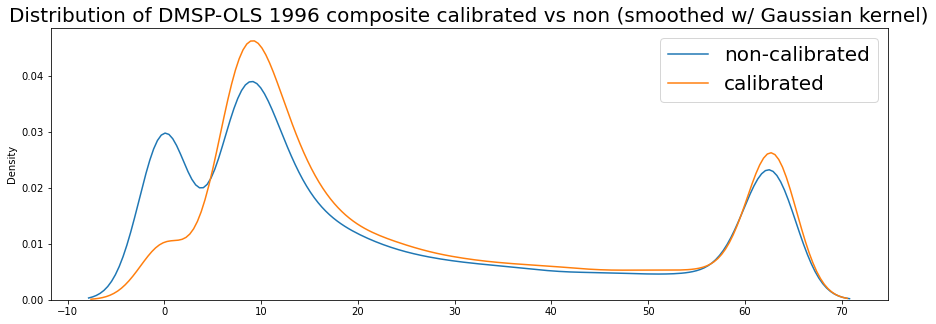

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp1996_arr.flatten(), label='non-calibrated',legend=True, ax=ax)
sns.kdeplot(dmsp1996_clbr_arr.flatten(), label='calibrated',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of DMSP-OLS 1996 composite calibrated vs non (smoothed w/ Gaussian kernel)', fontsize=20);

**Brief observations:** You can see that while both layers show a similar distribution, the calibration impacts the distribution (it seems to shift the distribution rightward, i.e. increases the values somewhat). 

Note that this distribution was smoothed for better visualization, which is why you have values less than 0 and higher than 63 for DN (x axis).

## Thinking programmically: creating a function to conduct calibration

We just calibrated a single annual composite by hard-coding the expression to show what's happening, but in general this is a **bad idea.** Rather, we should create a function, which is better for two very important reasons:
- functions are more efficient and reduce repetition when coding (especially if you want to a calibrate many images)
- they reduce the chance of human error when hand-writing or cutting-and-pasting data, such as our calibration coefficients or satellite names. Imagine the potential for error if you had to hand-copy each calibration coefficient every time you wrote the expression.

We've created a `.csv` file of our calibration coeffients, saved in this GitHub repo at `files/Elvidge_DMSP_intercalib.csv`. We're going to create a series of functions that get the satellite name and year from the Image itself, look up that particular satellite-year's calibration coefficients from our table, apply them to the image, and finally, clip the low and high DN values as we did before.

We can then use this function on any Image in our ImageCollection to return a calibrated and clipped version.

#### Define our functions

In [9]:
# load the calibration coefficients reference file
import pandas as pd
coef = pd.read_csv('files/Elvidge_DMSP_intercalib_coef.csv')

# define a function that takes an image, gets its name, and returns its coefficients
def get_coefs(img, coefdata=coef):
    imgID = img.id().getInfo()
    idx = coefdata['satellite']+coefdata['year'].astype(str)==imgID
    return coefdata.loc[idx, ['c0','c1','c2']].values[0]

# define a function that wraps the ee.Image native "expression" function 
# and passess the image coefficients as arguments to return the calibrated image
def calibrate_img(img):
    c0, c1, c2 = get_coefs(img)
    return img.expression("c0 + (c1 * X) + (c2 * X**2)", {'X':img, 'c0':c0, 'c1':c1, 'c2':c2})

# define a function that clips images
def clip_img(img, upper_thresh=63, upper_set=63, lower_thresh=6, lower_set=0):
    return img.where(img.gt(upper_thresh),upper_set).where(img.lte(lower_thresh),lower_set)

# wrap these in a single function using defaults
def calibrate_and_clip(img):
    return clip_img(calibrate_img(img))

#### Apply to an Image
Now that we have created our single function, `calibrate_and_clip()` that takes a single input, an ee.Image object, we can apply it to any Image we've created, without having to manually look up the calibration coefficients or even the satellite name. We can get that directly from the image object itself!

For example, let's take our 1996 composite (which we created above), and return a calibrated image, just as before, but this time using our new function.

In [10]:
# create a calibrated and clipped version from our 1996 composite but with our new function
dmsp1996_clbr2 = calibrate_and_clip(dmsp1996)

# let's create an array from this new image, just as before, so we can plot the distribution
dmsp1996_clbr2_arr = geemap.ee_to_numpy(dmsp1996_clbr2, region=myPolyGeom)

#### Sanity check: compare plots

Now let's compare the density plots of our new calibrated image `dmsp1996_clbr2` with the calibration we did manually before, `dmsp1996_clbr` -- they should be exactly the same!

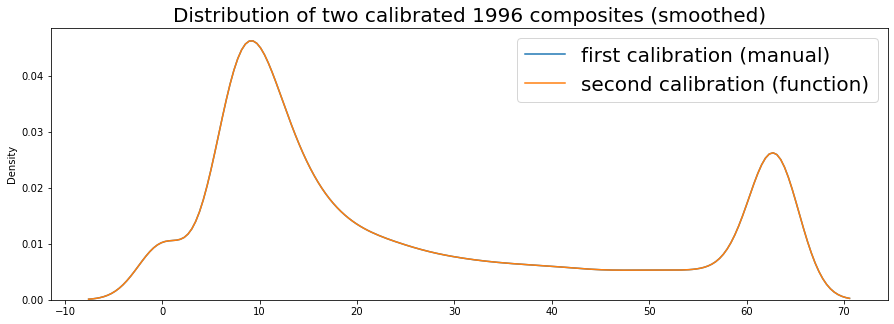

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp1996_clbr_arr.flatten(), label='first calibration (manual)',legend=True, ax=ax)
sns.kdeplot(dmsp1996_clbr2_arr.flatten(), label='second calibration (function)',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of two calibrated 1996 composites (smoothed)', fontsize=20);

Indeed, they are exactly the same!

In fact, the difference when subracting one array from the other is exactly zero for element in the array (i.e. pixel in the image):

In [12]:
dmsp1996_clbr_arr - dmsp1996_clbr2_arr

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

### Let's compare another year: 2007

This year has data from two overlapping satellites: F15 and F16, so can actually compare how calibration impacts them both.

First we'll retrieve and plot the intial composites:

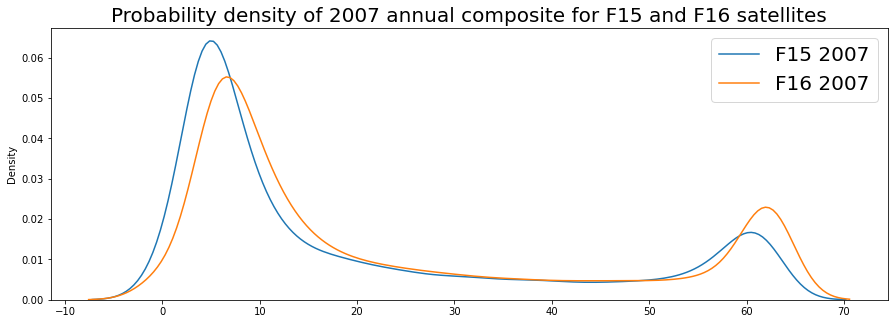

In [13]:
# initial images
dmspF152007 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F152007").select('stable_lights')
dmspF162007 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F162007").select('stable_lights')

# convert to arrays and plot
dmspF152007_arr = geemap.ee_to_numpy(dmspF152007, region=myPolyGeom)
dmspF162007_arr = geemap.ee_to_numpy(dmspF162007, region=myPolyGeom)

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmspF152007_arr.flatten(), label='F15 2007',legend=True, ax=ax)
sns.kdeplot(dmspF162007_arr.flatten(), label='F16 2007',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Probability density of 2007 annual composite for F15 and F16 satellites', fontsize=20);

While they are similar, you can see there is indeed a noticeable difference, particularly in lower and upper ranges, for example they diverge above about 50 DN.

If you were comparing city lights, which would be in that upper range range, above 50 DN, you might see a difference that is attributed not to actual observed light, but to the difference in sensors.

Now let's calibrate them both.

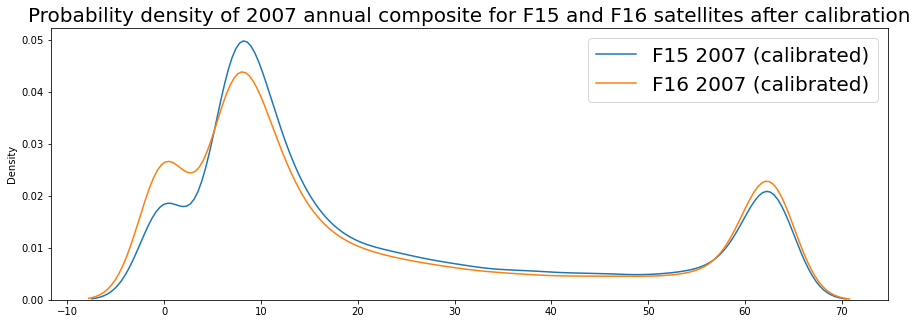

In [14]:
# calibrate both images
dmspF152007_clbr = calibrate_and_clip(dmspF152007)
dmspF162007_clbr = calibrate_and_clip(dmspF162007)

# convert to arrays and plot histograms
dmspF152007_clbr_arr = geemap.ee_to_numpy(dmspF152007_clbr, region=myPolyGeom)
dmspF162007_clbr_arr = geemap.ee_to_numpy(dmspF162007_clbr, region=myPolyGeom)

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmspF152007_clbr_arr.flatten(), label='F15 2007 (calibrated)',legend=True, ax=ax)
sns.kdeplot(dmspF162007_clbr_arr.flatten(), label='F16 2007 (calibrated)',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Probability density of 2007 annual composite for F15 and F16 satellites after calibration', fontsize=20);

They are not a perfect match (keep in mind, the calibration is still just an approximation!) but you can see that noticeable dviergence is now gone and the two images are very nearly aligned in the top part of the range and closer at the very low end of the range.

Calibration has made our composites across satellites more comparable!

This just scratched the surface in terms of intercalibration, which can be complicated as the methods and models get more complex. But hopefully this simple calibration allows you to get a more comparable time series with the DMSP-OLS data.

Also, you may have thought it would be nice to see an actual plot of time series data, since that's what we're talking about. Well no fear, we will cover that in another tutorial...stay tuned!

## References:
```{bibliography} ../references.bib
:filter: docname in docnames
```